In [2]:
import numpy as np 
import pandas as pd 
import warnings
import logging
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier
import matplotlib.pyplot as plt
import shap
!pip install Wittgenstein
import wittgenstein as lw
from sklearn.model_selection import GridSearchCV

/kaggle/input/dapprojekt24-1/train.csv
/kaggle/input/dapprojekt24-1/test.csv
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.6/110.6 kB 4.7 MB/s eta 0:00:00


In [3]:
# Suppress all warnings
warnings.filterwarnings("ignore")
# Disable LightGBM info messages
logging.getLogger('lightgbm').setLevel(logging.ERROR)

# 0. Data loading and basic info

In [4]:
# Load training and test datasets
train_df = pd.read_csv("/kaggle/input/dapprojekt24-1/train.csv")
test_df = pd.read_csv("/kaggle/input/dapprojekt24-1/test.csv")

In [5]:
train_df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Target,Id
0,2010-01-04,MMM,53.295380,83.019997,83.449997,82.669998,83.089996,3043700.0,0,0
1,2010-01-05,MMM,52.961575,82.500000,83.230003,81.699997,82.800003,2847000.0,0,1
2,2010-01-06,MMM,53.712681,83.669998,84.599998,83.510002,83.879997,5268500.0,0,2
3,2010-01-07,MMM,53.751179,83.730003,83.760002,82.120003,83.320000,4470100.0,0,3
4,2010-01-08,MMM,54.129955,84.320000,84.320000,83.300003,83.690002,3405800.0,0,4


In [6]:
train_df['Symbol'].unique()

array(['MMM', 'AOS', 'ACN', 'AES', 'A', 'AKAM', 'ALB', 'ALLE', 'LNT',
       'GOOGL', 'MO', 'AMZN', 'AXP', 'AWK', 'AME', 'ANSS', 'APA', 'AAPL',
       'AMAT', 'ADM', 'ANET', 'AIZ', 'T', 'BKR', 'BALL', 'BAC', 'BBY',
       'BIIB', 'BLK', 'BMY', 'AVGO', 'BG', 'CPB', 'CAH', 'CBOE', 'CHRW',
       'CHTR', 'CMG', 'CINF', 'CSCO', 'CFG', 'CME', 'CMS', 'KO', 'CAG',
       'ED', 'STZ', 'CTVA', 'CTRA', 'CMI', 'DVA', 'DE', 'XRAY', 'FANG',
       'DLR', 'DFS', 'DPZ', 'DHI', 'DTE', 'DUK', 'EBAY', 'EMR', 'ENPH',
       'EOG', 'EQIX', 'ESS', 'EL', 'EVRG', 'ES', 'EXPD', 'EXR', 'FFIV',
       'FAST', 'FIS', 'FE', 'FLT', 'FTV', 'FOXA', 'FCX', 'IT', 'GEHC',
       'GEN', 'GNRC', 'GM', 'GPC', 'GL', 'GS', 'HAS', 'PEAK', 'HSY',
       'HES', 'HLT', 'HST', 'HBAN', 'IBM', 'ILMN', 'PODD', 'INTC', 'IFF',
       'IP', 'ISRG', 'IVZ', 'INVH', 'IQV', 'JNJ', 'KVUE', 'KDP', 'KEY',
       'KEYS', 'KMB', 'KIM', 'KMI', 'KR', 'LVS', 'LDOS', 'LIN', 'LMT',
       'LYB', 'MPC', 'MKTX', 'MMC', 'MCD', 'MAA', 'MHK', 'TAP', 'MP

# 1. Cross-validation function

Function that contains 5-fold cross-validation and tests the following models: GaussianNB, LogisticRegression, RandomForestClassifier, ExtraTreesClassifier, and XGBClassifier. It returns table of f1 scores that are used as an evaluation metric.

In [7]:
models = {
        'GaussianNB\t': GaussianNB(),
        'LogisticRegression': LogisticRegression(),
        'RandomForestClassifier': RandomForestClassifier(),
        'ExtraTreesClassifier': ExtraTreesClassifier(),
        'XGBClassifier\t': XGBClassifier()
    }

def cross_validation(data, models, features):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    print("Algorithm\t\tFold 1\tFold 2\tFold 3\tFold 4\tFold 5\tAverage")
    
    averages = []
    for name, model in models.items():
        f1_scores = []
        print(f"{name}\t", end='')
        for train_index, test_index in kf.split(data):
            X_train, X_test = data.iloc[train_index], data.iloc[test_index]
            y_train, y_test = X_train['Target'], X_test['Target']
            X_train, X_test = X_train[features], X_test[features]
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            f1 = f1_score(y_test, predictions)
            f1_scores.append(f1)
            print(f"{f1:.4f}\t", end='')
        avg_f1 = np.mean(f1_scores)
        averages.append(round(avg_f1,4))
        print(f"{avg_f1:.4f}")
    return averages


In [8]:
features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
results = cross_validation(train_df[train_df['Symbol'] == "AAPL"], models, features)

best_model_index = results.index(max(results))
best_model = list(models.values())[best_model_index]
print("Best model is:", best_model)


Algorithm		Fold 1	Fold 2	Fold 3	Fold 4	Fold 5	Average
GaussianNB		0.9087	0.8967	0.8953	0.8965	0.9097	0.9014
LogisticRegression	0.9087	0.8991	0.8989	0.9037	0.9121	0.9045
RandomForestClassifier	0.9279	0.9152	0.9282	0.9132	0.9254	0.9220
ExtraTreesClassifier	0.9277	0.9183	0.9327	0.9192	0.9303	0.9257
XGBClassifier		0.9225	0.9281	0.9314	0.9117	0.9222	0.9232
Best model is: ExtraTreesClassifier()


### Creating function for testing

In [9]:
def testing(train_df, test_df, models, features):
    train_df.fillna(0, inplace=True)
    test_df.fillna(0, inplace=True)
    
    X_train = train_df[features]
    y_train = train_df['Target']
    X_test = test_df[features]
    
    #train_df = train_df.dropna()
    #imputer = SimpleImputer(strategy='mean')
    #X_test_imputed = imputer.fit_transform(X_test)
    
    results = cross_validation(train_df, models, features)
    best_model_index = results.index(max(results))
    best_model = list(models.values())[best_model_index]
    print("Best model is:", best_model)

    best_model.fit(X_train, y_train)
    predictions = best_model.predict(X_test)
    #predictions = best_model.predict(X_test_imputed)
        
    output = pd.DataFrame({'Id': test_df['Id'], 'Target': predictions})
    output_path = '/kaggle/working/submission.csv'
    output.to_csv(output_path, index=False)


### Running the cross-validation function

In [10]:
#testing(train_df, test_df, models, features)

print("Score on Public Leaderboard: 0.80999") 

Score on Public Leaderboard: 0.80999


# 2. New features


### Domain specific features

I created six domain specific features, and they include moving average, exponential moving average, MACD and relative strength index (RSI), which are frequently used in trading strategies.
I implemented those features to both train set and test set.

In [11]:
# Train data

new_train_data = train_df
# Moving average
new_train_data['MA_10'] = new_train_data['Close'].rolling(window=10).mean()
new_train_data['MA_50'] = new_train_data['Close'].rolling(window=50).mean()
# Exponential moving average
new_train_data['EMA_10'] = new_train_data['Close'].ewm(span=10, adjust=False).mean()
new_train_data['EMA_50'] = new_train_data['Close'].ewm(span=50, adjust=False).mean()
# MACD
new_train_data['ema_short'] = new_train_data['Close'].ewm(span=12, adjust=False).mean()
new_train_data['ema_long'] = new_train_data['Close'].ewm(span=26, adjust=False).mean()
new_train_data['MACD'] = new_train_data['ema_short']-new_train_data['ema_long']
# RSI
new_train_data['delta'] = new_train_data['Close'].diff()
gain = new_train_data['delta'].where(new_train_data['delta'] > 0, 0).rolling(window=14).mean()
loss = -new_train_data['delta'].where(new_train_data['delta'] < 0, 0).rolling(window=14).mean()
new_train_data['RSI'] = 100 - (100 / (1 + gain/loss))

new_train_data = new_train_data.drop(columns=['ema_short', 'ema_long', 'delta'])

#new_train_data.head(50)

# Test data
new_test_data = test_df
# Moving average
new_test_data['MA_10'] = new_test_data['Close'].rolling(window=10).mean()
new_test_data['MA_50'] = new_test_data['Close'].rolling(window=50).mean()
# Exponential moving average
new_test_data['EMA_10'] = new_test_data['Close'].ewm(span=10, adjust=False).mean()
new_test_data['EMA_50'] = new_test_data['Close'].ewm(span=50, adjust=False).mean()
# MACD
new_test_data['ema_short'] = new_test_data['Close'].ewm(span=12, adjust=False).mean()
new_test_data['ema_long'] = new_test_data['Close'].ewm(span=26, adjust=False).mean()
new_test_data['MACD'] = new_test_data['ema_short']-new_test_data['ema_long']
# RSI
new_test_data['delta'] = new_test_data['Close'].diff()
gain = new_test_data['delta'].where(new_test_data['delta'] > 0, 0).rolling(window=14).mean()
loss = -new_test_data['delta'].where(new_test_data['delta'] < 0, 0).rolling(window=14).mean()
loss = loss.replace(to_replace=0, value=0.0001)
new_test_data['RSI'] = 100 - (100 / (1 + gain/loss))

new_test_data = new_test_data.drop(columns=['ema_short', 'ema_long', 'delta'])

### History related features

Here are the 10 history related features that were created to enhance my results.

In [12]:
new_train_data['Close_pct_1'] = new_train_data['Close'].pct_change(1)
new_train_data['Close_pct_3'] = new_train_data['Close'].pct_change(3)
new_train_data['Close_pct_5'] = new_train_data['Close'].pct_change(5)
new_train_data['Close_pct_30'] = new_train_data['Close'].pct_change(30)
new_train_data['ROC_1'] = new_train_data['Close'].diff(1) / new_train_data['Close'].shift(1) * 100
new_train_data['ROC_3'] = new_train_data['Close'].diff(3) / new_train_data['Close'].shift(3) * 100
new_train_data['ROC_5'] = new_train_data['Close'].diff(5) / new_train_data['Close'].shift(5) * 100
new_train_data['ROC_30'] = new_train_data['Close'].diff(30) / new_train_data['Close'].shift(30) * 100
new_train_data['Return_skewness'] = new_train_data['Close'].pct_change(10).rolling(window=10).skew()
new_train_data['VWAP'] = (new_train_data['Close'] * new_train_data['Volume']).cumsum() / new_train_data['Volume'].cumsum()


new_test_data['Close_pct_1'] = new_test_data['Close'].pct_change(1)
new_test_data['Close_pct_3'] = new_test_data['Close'].pct_change(3)
new_test_data['Close_pct_5'] = new_test_data['Close'].pct_change(5)
new_test_data['Close_pct_30'] = new_test_data['Close'].pct_change(30)
new_test_data['ROC_1'] = new_test_data['Close'].diff(1) / new_test_data['Close'].shift(1) * 100
new_test_data['ROC_3'] = new_test_data['Close'].diff(3) / new_test_data['Close'].shift(3) * 100
new_test_data['ROC_5'] = new_test_data['Close'].diff(5) / new_test_data['Close'].shift(5) * 100
new_test_data['ROC_30'] = new_test_data['Close'].diff(30) / new_test_data['Close'].shift(30) * 100
new_test_data['Return_skewness'] = new_test_data['Close'].pct_change(10).rolling(window=10).skew()
new_test_data['VWAP'] = (new_test_data['Close'] * new_test_data['Volume']).cumsum() / new_test_data['Volume'].cumsum()

### Running the cross-validation function

In [13]:
new_features = ['MA_10', 'MA_50', 'EMA_10', 'EMA_50', 'MACD', 'RSI', 'Close_pct_1', 'Close_pct_3', 'Close_pct_5', 'Close_pct_30', 'ROC_1', 'ROC_3', 'ROC_5', 'ROC_30', 'Return_skewness', 'VWAP'] 
all_features = features + new_features

In [14]:
#cross_validation(new_train_data[new_train_data['Symbol'] == "AAPL"], models, all_features)
#testing(new_train_data, new_test_data, models, all_features)

print("Score on Public Leaderboard: 0.80749")


Score on Public Leaderboard: 0.80749


# 3. Wrapper method

Here I am trying to figure out which 12 features are the best predictors to use. I am doing that by training models with one feature excluded to find out which one is the worst and then I remove it.

In [15]:
def select_features(X, y, features):
    selected_features = list(features)
    features_needed = 12
    while len(selected_features) > features_needed:
        best_f1_score = 0
        feature_to_drop = None

        for feature in selected_features:
            features_to_use = [f for f in selected_features if f != feature]
            X_train, X_val, y_train, y_val = train_test_split(X[features_to_use], y, test_size=0.2, random_state=42)
            #model = LinearSVC() # probati poslije s ovim kad vidim koliko treba vremena
            model = HistGradientBoostingClassifier()
            model.fit(X_train, y_train)
            predictions = model.predict(X_val)
            f1 = f1_score(y_val, predictions)
            if f1 > best_f1_score:
                best_f1_score = f1
                feature_to_drop = feature

        selected_features.remove(feature_to_drop)
    print(f"Features that will be used in the next tasks are:\n{selected_features}")
    
    return selected_features


### Running the cross-validation function

In [17]:
X = new_train_data[new_features]
y = new_train_data['Target']
X_test = new_test_data[new_features]

#selected_features = select_features(X, y, new_features)
#testing(new_train_data, new_test_data, models, selected_features)
print("Score on Public Leaderboard: 0.80017")

Features that will be used in the next tasks are:
['MA_10', 'MA_50', 'EMA_10', 'EMA_50', 'MACD', 'Close_pct_3', 'Close_pct_5', 'Close_pct_30', 'ROC_3', 'ROC_30', 'Return_skewness', 'VWAP']
Score on Public Leaderboard: 0.80017


# 4. Explainability with SHAP


In [18]:
X = new_train_data[selected_features]

best_model = HistGradientBoostingClassifier()
best_model.fit(X, y)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)



Force plots for samples from 86 to 96



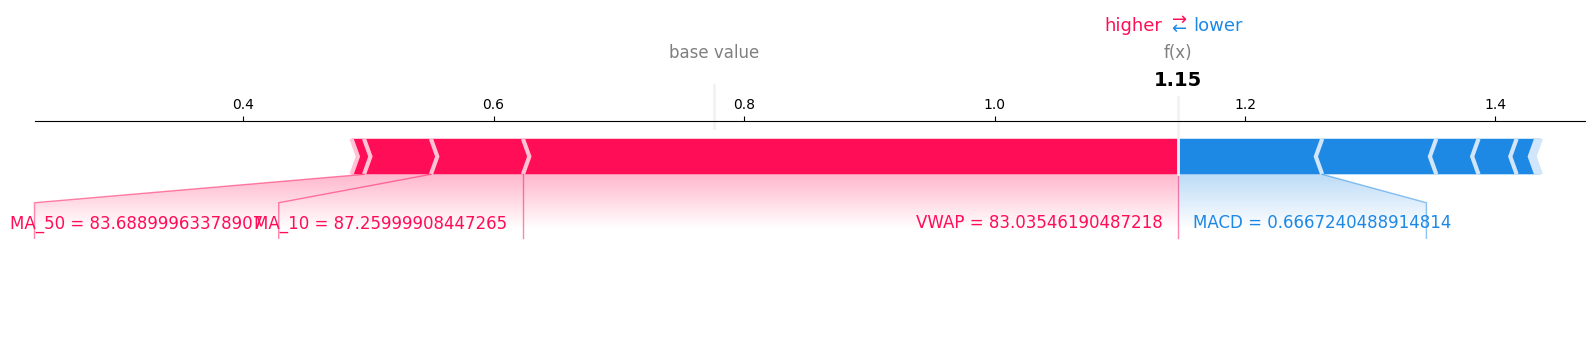

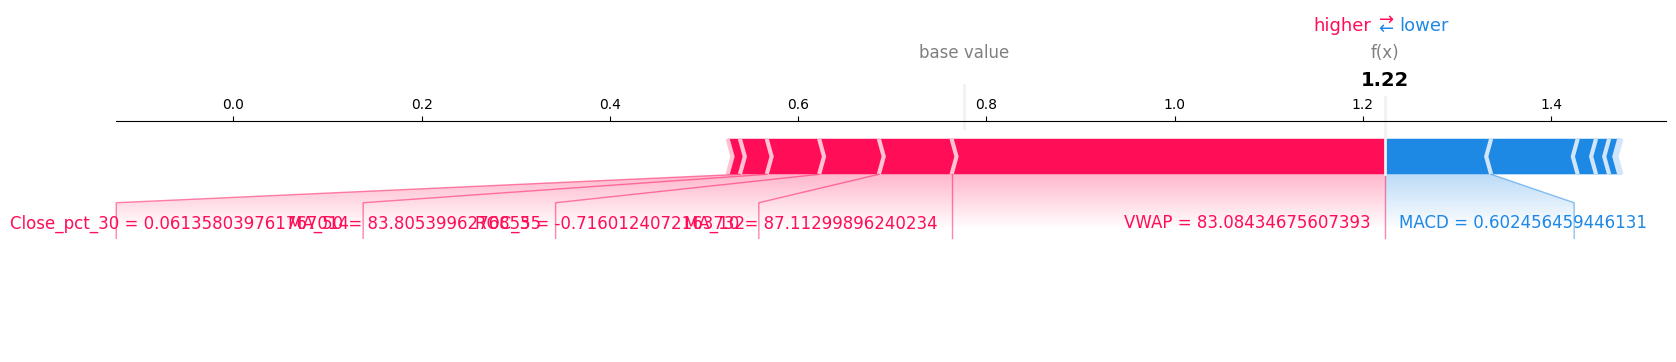

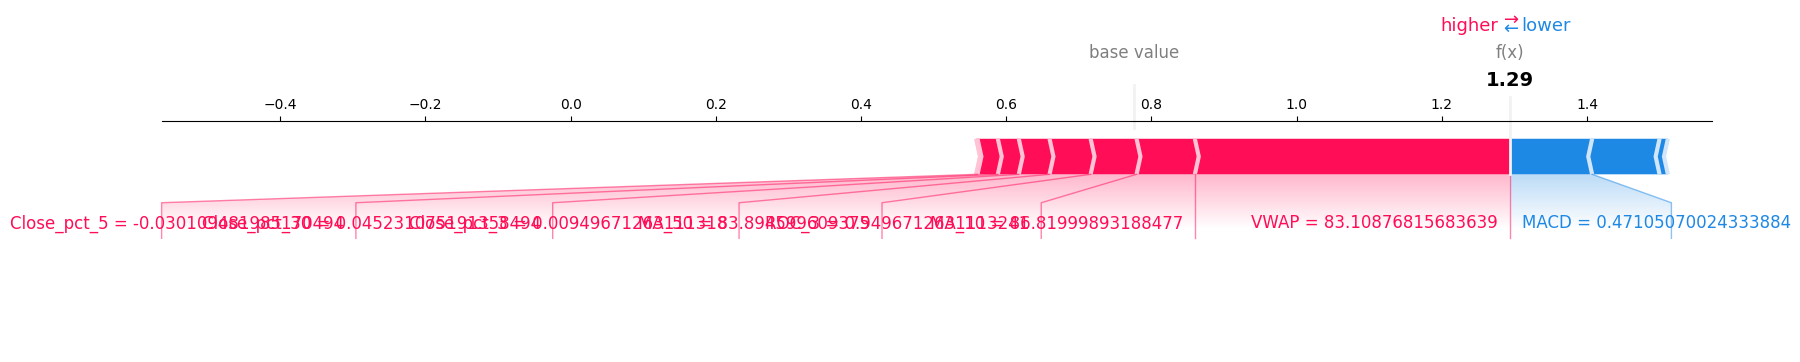

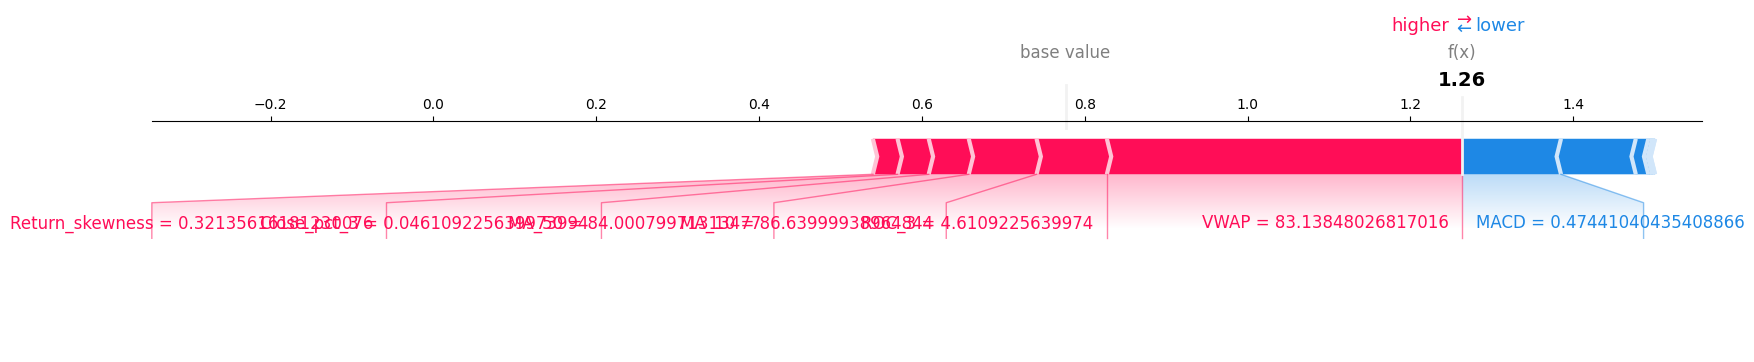

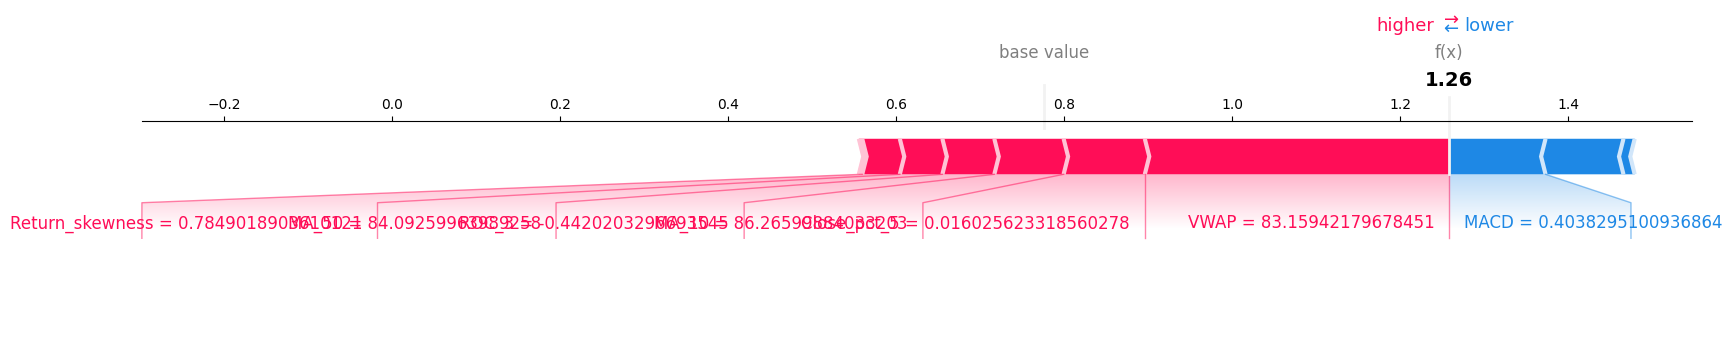

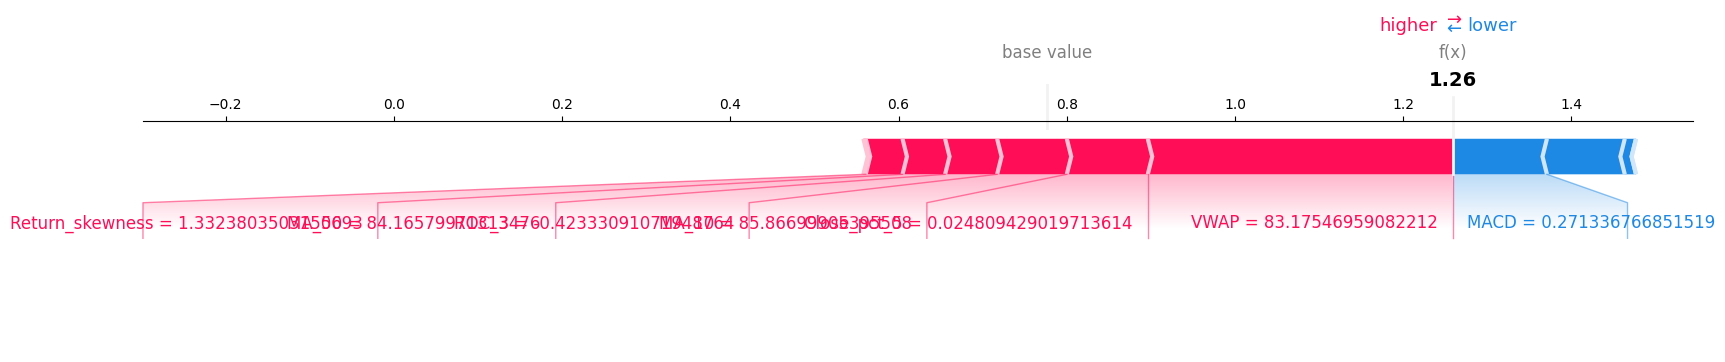

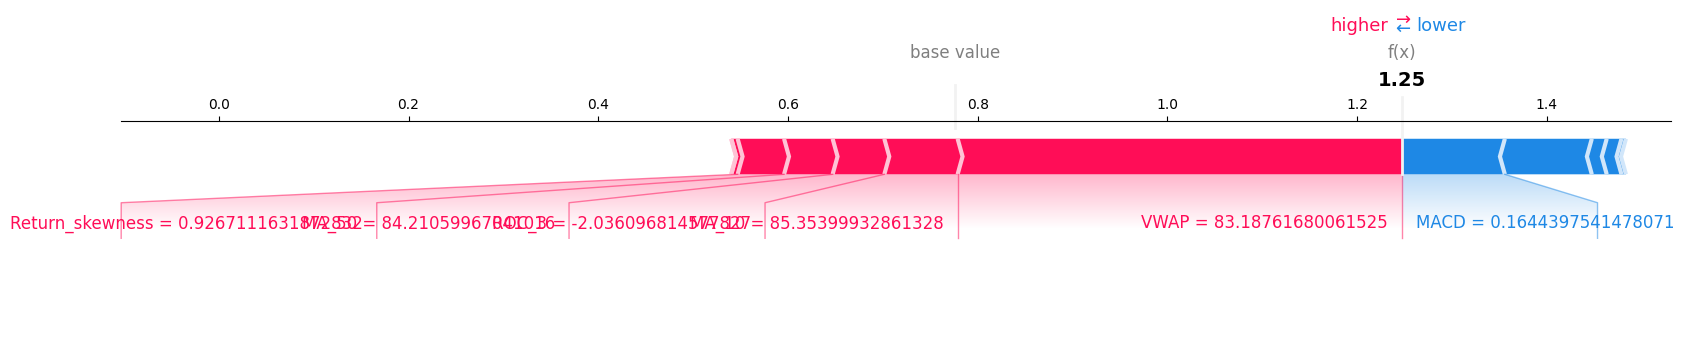

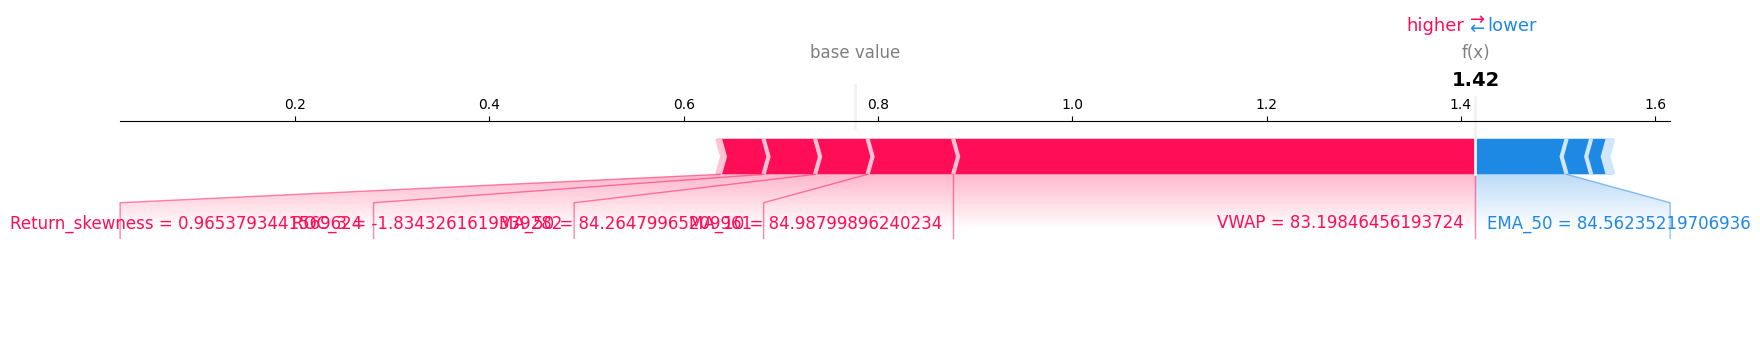

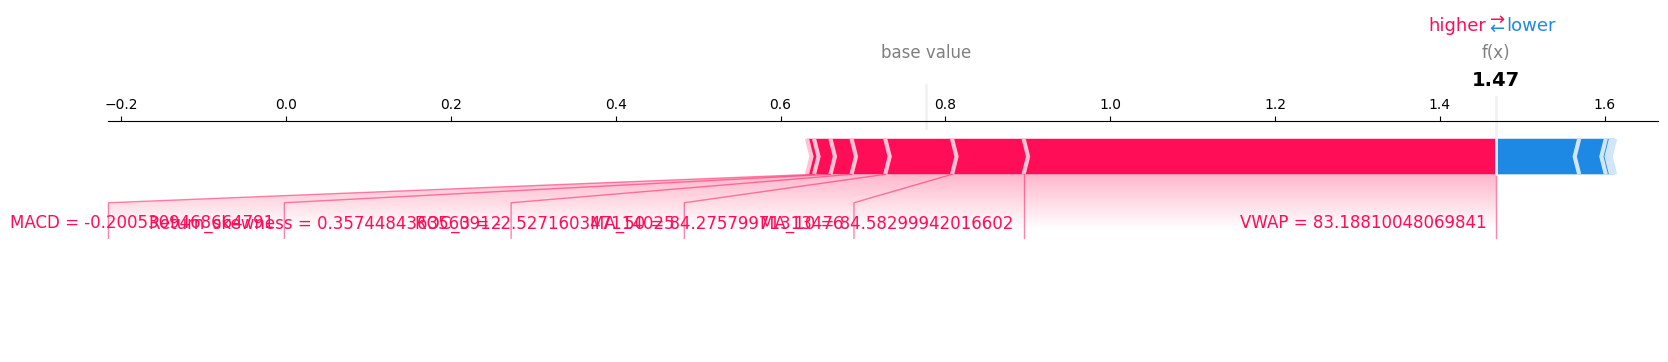

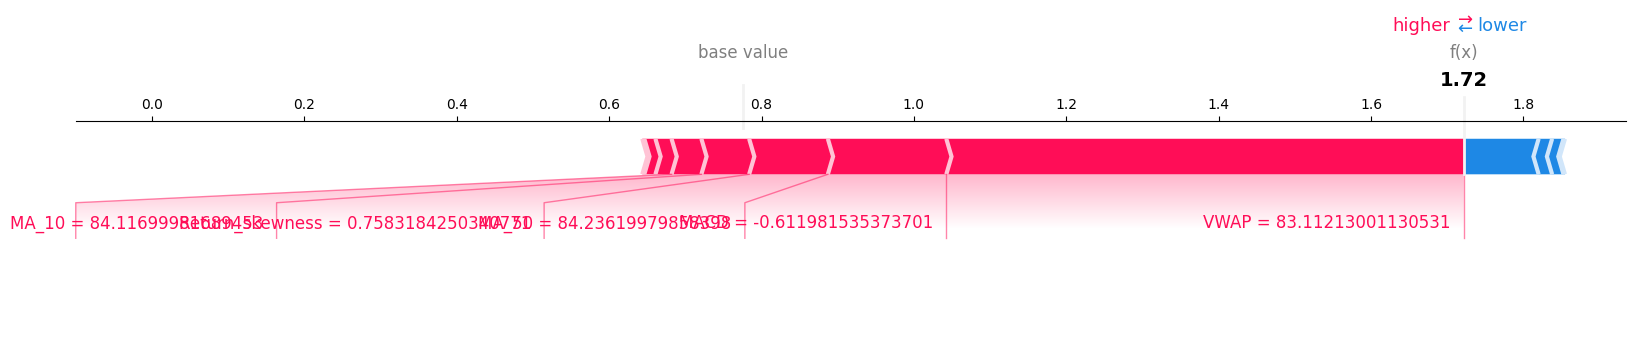

In [19]:
days = 5
for i in range(50, len(y) - days + 1):
    if sum(y[i-days:i]) < days and sum(y[i:i+days]) == days:
        sample = i-5
        break


print(f"\nForce plots for samples from {sample} to {sample+10}\n")
for i in range(10):
    shap.force_plot(explainer.expected_value, shap_values[sample+i], X.iloc[sample+i], matplotlib=True)

# 5. RIPPER optimization

In [20]:
my_stock = 'AAPL'
ripper_df = train_df[train_df['Symbol'] == my_stock]
X = ripper_df[['Volume']].values
y = ripper_df['Target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

ripper_model = lw.RIPPER()
ripper_model.fit(X_train, y_train)
predictions = ripper_model.predict(X_test)
f1 = f1_score(y_test, predictions)

print("F1 Score:", f1)
print("Rules:")
for rule in ripper_model.ruleset_.rules:
    print(rule)

params = {
    'k': [1, 2, 3],
    'prune_size': [0.1, 0.2, 0.3],
    'dl_allowance': [0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(estimator=ripper_model, param_grid=params, scoring='f1')
grid_search.fit(X_train, y_train)

optimized_model = grid_search.best_estimator_
optimized_predictions = optimized_model.predict(X_test)
optimized_f1 = f1_score(y_test, optimized_predictions)

print("\nOptimized F1 Score:", optimized_f1)
print("Optimized Rules:")
for rule in optimized_model.ruleset_.rules:
    print(rule)

max_rules = 3
max_rule_conds = 2
ripper_model_max = lw.RIPPER(max_rules=max_rules, max_rule_conds=max_rule_conds)
ripper_model_max.fit(X_train, y_train)

print("\nRules with Maximum Limits:")
for rule in ripper_model_max.ruleset_.rules:
    print(rule)


F1 Score: 0.5814634146341463
Rules:
[0=<89916320.0]
[0=221123600.0-284915120.0]
[0=89916320.0-110173680.0]
[0=284915120.0-372232560.0]

Optimized F1 Score: 0.48510638297872344
Optimized Rules:
[0=<89916320.0]
[0=89916320.0-110173680.0]
[0=221123600.0-284915120.0]

Rules with Maximum Limits:
[0=<89916320.0]
[0=89916320.0-110173680.0]
